# LangGraph 챗봇 구축

먼저 `LangGraph`를 사용하여 간단한 챗봇을 만들어 보겠습니다. 이 챗봇은 사용자 메시지에 직접 응답할 것입니다. 비록 간단하지만, `LangGraph`로 구축하는 핵심 개념을 설명할 것입니다. 이 섹션이 끝나면 기본적인 챗봇을 구축하게 될 것입니다.

`StateGraph`를 생성하는 것으로 시작하십시오. `StateGraph` 객체는 챗봇의 구조를 "상태 기계(State Machine)"로 정의합니다. 

`nodes`를 추가하여 챗봇이 호출할 수 있는 `llm`과 함수들을 나타내고, `edges`를 추가하여 봇이 이러한 함수들 간에 어떻게 전환해야 하는지를 지정합니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

## Step-by-Step 개념 이해하기!

### STEP 1. 상태(State) 정의

In [2]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]

### STEP 2. 노드(Node) 정의

다음으로 "`chatbot`" 노드를 추가합니다. 

노드는 작업의 단위를 나타내며, 일반적으로 정규 **Python** 함수입니다.

In [3]:
from langchain_openai import ChatOpenAI

# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}

### STEP 3. 그래프(Graph) 정의, 노드 추가

In [4]:
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

**참고**

- `chatbot` 노드 함수는 현재 `State`를 입력으로 받아 "messages"라는 키 아래에 업데이트된 `messages` 목록을 포함하는 사전(TypedDict) 을 반환합니다. 

- `State`의 `add_messages` 함수는 이미 상태에 있는 메시지에 llm의 응답 메시지를 추가합니다. 

### STEP 4. 그래프 엣지(Edge) 추가

다음으로, `START` 지점을 추가하세요. `START`는 그래프가 실행될 때마다 **작업을 시작할 위치** 입니다.

In [5]:
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")


마찬가지로, `END` 지점을 설정하십시오. 이는 그래프 흐름의 종료(끝지점) 를 나타냅니다.

In [6]:
# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

### STEP 5. 그래프 컴파일(compile)

마지막으로, 그래프를 실행할 수 있어야 합니다. 이를 위해 그래프 빌더에서 "`compile()`"을 호출합니다. 이렇게 하면 상태에서 호출할 수 있는 "`CompiledGraph`"가 생성됩니다.

In [7]:
# 그래프 컴파일
graph = graph_builder.compile()

### STEP 6. 그래프 시각화

이제 그래프를 시각화해봅시다.

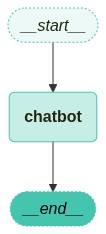

In [8]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

### STEP 7. 그래프 실행

이제 챗봇을 실행해봅시다!

In [9]:
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print("Assistant:", value["messages"][-1].content)

Assistant: 서울에는 다양한 맛집이 많아서 선택하기가 쉽지 않지만, 다음은 서울에서 유명한 맛집 TOP 10을 추천해 드립니다. 각 식당은 고유의 매력을 가지고 있으니 참고해 보세요!

1. **광장시장** - 전통 시장으로, 빈대떡, 마약김밥, 떡볶이 등 다양한 길거리 음식을 즐길 수 있습니다.

2. **부암동 카페거리** - 예쁜 카페와 맛있는 디저트가 많은 곳으로, 특히 '카페 드 파리'의 생과일 빙수가 유명합니다.

3. **이태원 앤틱 가구 거리** - 다양한 국제 요리를 즐길 수 있는 곳으로, '부리또'와 '타이 음식'이 인기입니다.

4. **명동 교자** - 칼국수와 만두가 유명한 맛집으로, 항상 많은 사람들이 찾는 곳입니다.

5. **삼청동 수제비** - 전통 수제비와 함께 다양한 한식을 즐길 수 있는 곳입니다.

6. **신사동 가로수길** - 다양한 트렌디한 레스토랑과 카페가 모여 있는 곳으로, '브런치 카페'가 특히 인기가 많습니다.

7. **종로 통인시장** - 다양한 전통 음식을 맛볼 수 있는 시장으로, 특히 '김밥'과 '떡'이 유명합니다.

8. **홍대** - 다양한 음식점과 카페가 밀집해 있는 지역으로, '홍대 돈부리'와 '버거'가 인기입니다.

9. **압구정 로데오거리** - 고급 레스토랑과 카페가 많은 곳으로, '스시'와 '프렌치 레스토랑'이 유명합니다.

10. **여의도 한강공원** - 피크닉을 즐기며 다양한 길거리 음식을 맛볼 수 있는 곳으로, 특히 '핫도그'와 '치킨'이 인기입니다.

각 지역마다 특색 있는 음식들이 많으니, 방문하실 때 참고하시기 바랍니다!


자! 여기까지가 가장 기본적인 챗봇 구축이었습니다. 

아래는 이전 과정을 정리한 전체 코드입니다.

## 전체 코드

In [ ]:
from typing import Annotated, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_teddynote.graphs import visualize_graph


###### STEP 1. 상태(State) 정의 ######
class State(TypedDict):
    # 메시지 정의(list type 이며 add_messages 함수를 사용하여 메시지를 추가)
    messages: Annotated[list, add_messages]


###### STEP 2. 노드(Node) 정의 ######
# LLM 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)


# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm.invoke(state["messages"])]}


###### STEP 3. 그래프(Graph) 정의, 노드 추가 ######
# 그래프 생성
graph_builder = StateGraph(State)

# 노드 이름, 함수 혹은 callable 객체를 인자로 받아 노드를 추가
graph_builder.add_node("chatbot", chatbot)

###### STEP 4. 그래프 엣지(Edge) 추가 ######
# 시작 노드에서 챗봇 노드로의 엣지 추가
graph_builder.add_edge(START, "chatbot")

# 그래프에 엣지 추가
graph_builder.add_edge("chatbot", END)

###### STEP 5. 그래프 컴파일(compile) ######
# 그래프 컴파일
graph = graph_builder.compile()

###### STEP 6. 그래프 시각화 ######
# 그래프 시각화
visualize_graph(graph)

###### STEP 7. 그래프 실행 ######
question = "서울의 유명한 맛집 TOP 10 추천해줘"

# 그래프 이벤트 스트리밍
for event in graph.stream({"messages": [("user", question)]}):
    # 이벤트 값 출력
    for value in event.values():
        print(value["messages"][-1].content)